In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("/content/Hitters.csv")
df = df.dropna()

# **Part I: Different Model Specs**

In [3]:
X = df.drop("Salary", axis = 1)
y = df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
ct = ColumnTransformer(
  [("dummify",
  OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
  make_column_selector(dtype_include = object)),
  ("standardize",
  StandardScaler(),
  make_column_selector(dtype_include = np.number))],
  remainder = "passthrough"
  ).set_output(transform = "pandas")

### **A. Regression without regularization**

In [5]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
  )

In [6]:
lr_fitted = lr_pipeline.fit(X_train, y_train)

In [7]:
lr_coefs = lr_fitted['linear_regression'].coef_
lr_coef_names = lr_fitted["preprocessing"].get_feature_names_out()
df_lr_coef = pd.DataFrame({"Variable": lr_coef_names, "Coef": lr_coefs, "Abs": np.abs(lr_coefs)})
print(lr_fitted["linear_regression"].intercept_)
print(df_lr_coef.sort_values(by = "Abs", ascending = False))

514.4741617406308
                Variable         Coef          Abs
13   standardize__CAtBat -1246.616666  1246.616666
14    standardize__CHits   955.588483   955.588483
16    standardize__CRuns   490.203803   490.203803
7      standardize__Hits   293.022451   293.022451
6     standardize__AtBat  -258.591107   258.591107
15   standardize__CHmRun   183.736415   183.736415
18   standardize__CWalks  -175.135742   175.135742
11    standardize__Walks   115.350491   115.350491
19  standardize__PutOuts    68.881573    68.881573
10      standardize__RBI   -64.837281    64.837281
9      standardize__Runs   -57.063186    57.063186
1      dummify__League_N    55.856433    55.856433
0      dummify__League_A   -55.856433    55.856433
20  standardize__Assists    51.920653    51.920653
12    standardize__Years    48.387323    48.387323
8     standardize__HmRun    39.236465    39.236465
4   dummify__NewLeague_A    37.393899    37.393899
5   dummify__NewLeague_N   -37.393899    37.393899
2    dummify_

The intercept means that if all variables = 0, the default expected salary would be $

In [8]:
cross_val_score(lr_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean()

np.float64(-121136.31031816891)

### **B. Ridge regression**

In [51]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
  ).set_output(transform = "pandas")
alphas_ridge = {"ridge_regression__alpha": np.array([100, 10, 1, 0.1, 0.01])}
gscv_ridge = GridSearchCV(ridge_pipeline, param_grid = alphas_ridge, cv = 5, scoring = "neg_mean_squared_error")

In [10]:
gscv_ridge_fitted = gscv_ridge.fit(X, y)
ridge_results = pd.DataFrame(gscv_ridge_fitted.cv_results_)
ridge_results[["param_ridge_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_ridge_regression__alpha,mean_test_score,rank_test_score
2,1.00,-119144.432677,1
1,10.00,-119348.984776,2
3,0.10,-120343.621067,3
0,100.00,-120716.435589,4
4,0.01,-121022.903286,5


In [11]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))]
  ).set_output(transform = "pandas")

In [12]:
ridge_fitted = ridge_pipeline.fit(X_train, y_train)

In [13]:
ridge_coefs = ridge_fitted["ridge_regression"].coef_
ridge_coef_names = ridge_fitted["preprocessing"].get_feature_names_out()
df_ridge_coef = pd.DataFrame({"Variable": ridge_coef_names, "Coef": ridge_coefs, "Abs": np.abs(ridge_coefs)})
print(ridge_fitted["ridge_regression"].intercept_)
print(df_ridge_coef.sort_values(by = "Abs", ascending = False))

514.9062644934905
                Variable        Coef         Abs
13   standardize__CAtBat -488.651780  488.651780
16    standardize__CRuns  468.982820  468.982820
7      standardize__Hits  338.021311  338.021311
6     standardize__AtBat -300.429647  300.429647
14    standardize__CHits  258.677311  258.677311
18   standardize__CWalks -217.031467  217.031467
11    standardize__Walks  127.961063  127.961063
15   standardize__CHmRun  125.972679  125.972679
17     standardize__CRBI   93.945457   93.945457
19  standardize__PutOuts   70.064776   70.064776
10      standardize__RBI  -59.248185   59.248185
9      standardize__Runs  -49.934743   49.934743
3    dummify__Division_W  -43.846465   43.846465
2    dummify__Division_E   43.846465   43.846465
1      dummify__League_N   42.695556   42.695556
0      dummify__League_A  -42.695556   42.695556
20  standardize__Assists   37.791222   37.791222
8     standardize__HmRun   29.258188   29.258188
4   dummify__NewLeague_A   27.026212   27.026212
5 

The intercept means that if all variables = 0, the default expected salary would be $

In [14]:
cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean()

np.float64(-119144.43267691585)

### **C. Lasso Regression**

In [55]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
  ).set_output(transform = "pandas")
alphas_lasso = {"lasso_regression__alpha": np.array([100, 10, 1, 0.1, 0.01])}
gscv_lasso = GridSearchCV(lasso_pipeline, param_grid = alphas_lasso, cv = 5, scoring = "neg_mean_squared_error")

In [ ]:
gscv_lasso_fitted = gscv_lasso.fit(X, y)
lasso_results = pd.DataFrame(gscv_lasso_fitted.cv_results_)
lasso_results[["param_lasso_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

In [17]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 1))]
  ).set_output(transform = "pandas")

In [18]:
lasso_fitted = lasso_pipeline.fit(X_train, y_train)

In [19]:
lasso_coefs = lasso_fitted["lasso_regression"].coef_
lasso_coef_names = lasso_fitted["preprocessing"].get_feature_names_out()
df_lasso_coef = pd.DataFrame({"Variable": lasso_coef_names, "Coef": lasso_coefs, "Abs": np.abs(lasso_coefs)})
print(lasso_fitted["lasso_regression"].intercept_)
print(df_lasso_coef.sort_values(by = "Abs", ascending = False))

497.5351578433727
                Variable          Coef           Abs
13   standardize__CAtBat -8.517882e+02  8.517882e+02
14    standardize__CHits  6.109571e+02  6.109571e+02
16    standardize__CRuns  4.882531e+02  4.882531e+02
7      standardize__Hits  2.936747e+02  2.936747e+02
6     standardize__AtBat -2.796890e+02  2.796890e+02
18   standardize__CWalks -1.817230e+02  1.817230e+02
15   standardize__CHmRun  1.679535e+02  1.679535e+02
11    standardize__Walks  1.098829e+02  1.098829e+02
2    dummify__Division_E  7.279912e+01  7.279912e+01
0      dummify__League_A -7.254851e+01  7.254851e+01
19  standardize__PutOuts  7.040815e+01  7.040815e+01
20  standardize__Assists  3.985924e+01  3.985924e+01
9      standardize__Runs -3.779911e+01  3.779911e+01
4   dummify__NewLeague_A  3.526846e+01  3.526846e+01
10      standardize__RBI -3.281637e+01  3.281637e+01
8     standardize__HmRun  1.325054e+01  1.325054e+01
12    standardize__Years  4.725983e+00  4.725983e+00
21   standardize__Errors -2.

The intercept means that if all variables = 0, the default expected salary would be $

In [20]:
cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(


np.float64(-119761.58740741308)

### **D. Elastic Net**

In [21]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio = 0.5))]
  )
param_grid = {
  "elastic_net__alpha": [1, 10, 100],
  "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
  }
gscv_elastic = GridSearchCV(elastic_pipeline, param_grid = param_grid, cv = 5, scoring = "neg_mean_squared_error")

In [ ]:
elastic_pipeline_fitted = gscv_elastic.fit(X, y)
elastic_results = pd.DataFrame(elastic_pipeline_fitted.cv_results_)
elastic_results[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "rank_test_score"]].sort_values(by = "rank_test_score")

In [23]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio = 1))]
  )

In [24]:
elastic_fitted = elastic_pipeline.fit(X_train, y_train)

In [25]:
elastic_coefs = elastic_fitted["elastic_net"].coef_
elastic_coef_names = elastic_fitted["preprocessing"].get_feature_names_out()
df_elastic_coef = pd.DataFrame({"Variable": elastic_coef_names, "Coef": elastic_coefs, "Abs": np.abs(elastic_coefs)})
print(elastic_fitted["elastic_net"].intercept_)
print(df_elastic_coef.sort_values(by = "Abs", ascending = False))

497.5351578433727
                Variable          Coef           Abs
13   standardize__CAtBat -8.517882e+02  8.517882e+02
14    standardize__CHits  6.109571e+02  6.109571e+02
16    standardize__CRuns  4.882531e+02  4.882531e+02
7      standardize__Hits  2.936747e+02  2.936747e+02
6     standardize__AtBat -2.796890e+02  2.796890e+02
18   standardize__CWalks -1.817230e+02  1.817230e+02
15   standardize__CHmRun  1.679535e+02  1.679535e+02
11    standardize__Walks  1.098829e+02  1.098829e+02
2    dummify__Division_E  7.279912e+01  7.279912e+01
0      dummify__League_A -7.254851e+01  7.254851e+01
19  standardize__PutOuts  7.040815e+01  7.040815e+01
20  standardize__Assists  3.985924e+01  3.985924e+01
9      standardize__Runs -3.779911e+01  3.779911e+01
4   dummify__NewLeague_A  3.526846e+01  3.526846e+01
10      standardize__RBI -3.281637e+01  3.281637e+01
8     standardize__HmRun  1.325054e+01  1.325054e+01
12    standardize__Years  4.725983e+00  4.725983e+00
21   standardize__Errors -2.

The intercept means that if all variables = 0, the default expected salary would be $

In [26]:
cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(


np.float64(-119761.58740741308)

# **Part II. Variable Selection**

* Which *numeric* variable is most important: `AtBat`
* Which *five* numeric variables are most important: `AtBat`, `CRBI`, `CHits`, `CWalks`, `Hits`
* Which *categorical* variable is most important: `Division_W`, `Division_E`, `League_A`, `League_N`, `NewLeague_A`

These variables had the highest absolute coefficients across the 4 models.

In [35]:
# 1 NUMERIC
X_n = df[["AtBat"]]
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y)

In [32]:
# 5 NUMERIC
X_5 = df[["AtBat", "CRBI", "CHits", "CWalks", "Hits"]]
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y)

In [33]:
# CATEGORICAL
X_c = df[["Division", "League", "NewLeague"]]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y)

In [37]:
# LINEAR 1 NUMERIC
lr_fitted_n = lr_pipeline.fit(X_train_n, y_train_n)
lr_coefs_n = lr_fitted_n['linear_regression'].coef_
lr_coef_names_n = lr_fitted_n["preprocessing"].get_feature_names_out()
df_lr_coef_n = pd.DataFrame({"Variable": lr_coef_names_n, "Coef": lr_coefs_n, "Abs": np.abs(lr_coefs_n)})
print(lr_fitted_n["linear_regression"].intercept_)
print(df_lr_coef_n.sort_values(by = "Abs", ascending = False))

553.9162842639594
             Variable        Coef         Abs
0  standardize__AtBat  237.280514  237.280514


In [38]:
# LINEAR 5 NUMERIC
lr_fitted_5 = lr_pipeline.fit(X_train_5, y_train_5)
lr_coefs_5 = lr_fitted_5['linear_regression'].coef_
lr_coef_names_5 = lr_fitted_5["preprocessing"].get_feature_names_out()
df_lr_coef_5 = pd.DataFrame({"Variable": lr_coef_names_5, "Coef": lr_coefs_5, "Abs": np.abs(lr_coefs_5)})
print(lr_fitted_5["linear_regression"].intercept_)
print(df_lr_coef_5.sort_values(by = "Abs", ascending = False))

555.0330304568528
              Variable        Coef         Abs
4    standardize__Hits  407.788198  407.788198
0   standardize__AtBat -240.007060  240.007060
1    standardize__CRBI  185.675996  185.675996
3  standardize__CWalks   34.267271   34.267271
2   standardize__CHits   12.075618   12.075618


In [39]:
# LINEAR CATEGORICAL
lr_fitted_c = lr_pipeline.fit(X_train_c, y_train_c)
lr_coefs_c = lr_fitted_c['linear_regression'].coef_
lr_coef_names_c = lr_fitted_c["preprocessing"].get_feature_names_out()
df_lr_coef_c = pd.DataFrame({"Variable": lr_coef_names_c, "Coef": lr_coefs_c, "Abs": np.abs(lr_coefs_c)})
print(lr_fitted_c["linear_regression"].intercept_)
print(df_lr_coef_c.sort_values(by = "Abs", ascending = False))

532.1684134416055
               Variable       Coef        Abs
1   dummify__Division_W -82.878464  82.878464
0   dummify__Division_E  82.878464  82.878464
2     dummify__League_A -18.555245  18.555245
3     dummify__League_N  18.555245  18.555245
4  dummify__NewLeague_A   0.413999   0.413999
5  dummify__NewLeague_N  -0.413999   0.413999


In [ ]:
# LINEAR 1 NUMERIC
lr_fitted_n = lr_pipeline.fit(X_train_n, y_train_n)
lr_coefs_n = lr_fitted_n['linear_regression'].coef_
lr_coef_names_n = lr_fitted_n["preprocessing"].get_feature_names_out()
df_lr_coef_n = pd.DataFrame({"Variable": lr_coef_names_n, "Coef": lr_coefs_n, "Abs": np.abs(lr_coefs_n)})
print(lr_fitted_n["linear_regression"].intercept_)
print(df_lr_coef_n.sort_values(by = "Abs", ascending = False))

In [45]:
# RIDGE 1 NUMERIC
gscv_ridge_fitted_n = gscv_ridge.fit(X_n, y)
ridge_results_n = pd.DataFrame(gscv_ridge_fitted_n.cv_results_)
ridge_results_n[["param_ridge_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_ridge_regression__alpha,mean_test_score,rank_test_score
1,10.00,-180201.072364,1
2,1.00,-180490.603072,2
3,0.10,-180527.393046,3
4,0.01,-180531.157205,4
0,100.00,-181208.465363,5


In [47]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))]
  ).set_output(transform = "pandas")
ridge_fitted_n = ridge_pipeline.fit(X_train_n, y_train_n)
ridge_coefs_n = ridge_fitted_n["ridge_regression"].coef_
ridge_coef_names_n = ridge_fitted_n["preprocessing"].get_feature_names_out()
df_ridge_coef_n = pd.DataFrame({"Variable": ridge_coef_names_n, "Coef": ridge_coefs_n, "Abs": np.abs(ridge_coefs_n)})
print(ridge_fitted_n["ridge_regression"].intercept_)
print(df_ridge_coef_n.sort_values(by = "Abs", ascending = False))

553.9162842639594
             Variable        Coef         Abs
0  standardize__AtBat  225.817687  225.817687


In [49]:
# RIDGE 5 NUMERIC
gscv_ridge_fitted_5 = gscv_ridge.fit(X_5, y)
ridge_results_5 = pd.DataFrame(gscv_ridge_fitted_n.cv_results_)
ridge_results_5[["param_ridge_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_ridge_regression__alpha,mean_test_score,rank_test_score
1,10.00,-180201.072364,1
2,1.00,-180490.603072,2
3,0.10,-180527.393046,3
4,0.01,-180531.157205,4
0,100.00,-181208.465363,5


In [50]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))]
  ).set_output(transform = "pandas")
ridge_fitted_5 = ridge_pipeline.fit(X_train_5, y_train_5)
ridge_coefs_5 = ridge_fitted_5["ridge_regression"].coef_
ridge_coef_names_5 = ridge_fitted_5["preprocessing"].get_feature_names_out()
df_ridge_coef_5 = pd.DataFrame({"Variable": ridge_coef_names_5, "Coef": ridge_coefs_5, "Abs": np.abs(ridge_coefs_5)})
print(ridge_fitted_5["ridge_regression"].intercept_)
print(df_ridge_coef_5.sort_values(by = "Abs", ascending = False))

555.0330304568529
              Variable        Coef         Abs
4    standardize__Hits  221.867126  221.867126
1    standardize__CRBI  133.673122  133.673122
2   standardize__CHits   63.271020   63.271020
0   standardize__AtBat  -58.084578   58.084578
3  standardize__CWalks   33.744081   33.744081


In [52]:
# RIDGE CATEGORICAL
gscv_ridge_fitted_c = gscv_ridge.fit(X_c, y)
ridge_results_c = pd.DataFrame(gscv_ridge_fitted_c.cv_results_)
ridge_results_c[["param_ridge_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_ridge_regression__alpha,mean_test_score,rank_test_score
1,10.00,-201572.940855,1
0,100.00,-201840.260813,2
2,1.00,-201915.352379,3
3,0.10,-201968.837319,4
4,0.01,-201974.486259,5


In [53]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))]
  ).set_output(transform = "pandas")
ridge_fitted_c = ridge_pipeline.fit(X_train_c, y_train_c)
ridge_coefs_c = ridge_fitted_c["ridge_regression"].coef_
ridge_coef_names_c = ridge_fitted_c["preprocessing"].get_feature_names_out()
df_ridge_coef_c = pd.DataFrame({"Variable": ridge_coef_names_c, "Coef": ridge_coefs_c, "Abs": np.abs(ridge_coefs_c)})
print(ridge_fitted_c["ridge_regression"].intercept_)
print(df_ridge_coef_c.sort_values(by = "Abs", ascending = False))

531.9638788496103
               Variable       Coef        Abs
1   dummify__Division_W -75.293602  75.293602
0   dummify__Division_E  75.293602  75.293602
3     dummify__League_N  14.446239  14.446239
2     dummify__League_A -14.446239  14.446239
5  dummify__NewLeague_N   2.714686   2.714686
4  dummify__NewLeague_A  -2.714686   2.714686


In [57]:
# LASSO 1 NUMERIC
gscv_lasso_fitted_n = gscv_lasso.fit(X_n, y)
lasso_results_n = pd.DataFrame(gscv_lasso_fitted_n.cv_results_)
lasso_results_n[["param_lasso_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_lasso_regression__alpha,mean_test_score,rank_test_score
1,10.00,-180513.915287,1
2,1.00,-180520.538995,2
3,0.10,-180530.379955,3
4,0.01,-180531.455837,4
0,100.00,-189626.266785,5


In [65]:
lasso_pipeline_10 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 10))]
  ).set_output(transform = "pandas")
lasso_fitted_n = lasso_pipeline_10.fit(X_train_n, y_train_n)
lasso_coefs_n = lasso_fitted_n["lasso_regression"].coef_
lasso_coef_names_n = lasso_fitted_n["preprocessing"].get_feature_names_out()
df_lasso_coef_n = pd.DataFrame({"Variable": lasso_coef_names_n, "Coef": lasso_coefs_n, "Abs": np.abs(lasso_coefs_n)})
print(lasso_fitted_n["lasso_regression"].intercept_)
print(df_lasso_coef_n.sort_values(by = "Abs", ascending = False))

553.9162842639594
             Variable        Coef         Abs
0  standardize__AtBat  227.280514  227.280514


In [60]:
# LASSO 5 NUMERIC
gscv_lasso_fitted_5 = gscv_lasso.fit(X_5, y)
lasso_results_5 = pd.DataFrame(gscv_lasso_fitted_5.cv_results_)
lasso_results_5[["param_lasso_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_lasso_regression__alpha,mean_test_score,rank_test_score
2,1.00,-126513.245077,1
3,0.10,-127113.091976,2
4,0.01,-127191.712963,3
1,10.00,-127803.840426,4
0,100.00,-142639.136716,5


In [61]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 1))]
  ).set_output(transform = "pandas")
lasso_fitted_5 = lasso_pipeline.fit(X_train_5, y_train_5)
lasso_coefs_5 = lasso_fitted_5["lasso_regression"].coef_
lasso_coef_names_5 = lasso_fitted_5["preprocessing"].get_feature_names_out()
df_lasso_coef_5 = pd.DataFrame({"Variable": lasso_coef_names_5, "Coef": lasso_coefs_5, "Abs": np.abs(lasso_coefs_5)})
print(lasso_fitted_5["lasso_regression"].intercept_)
print(df_lasso_coef_5.sort_values(by = "Abs", ascending = False))

555.0330304568529
              Variable        Coef         Abs
4    standardize__Hits  382.024495  382.024495
0   standardize__AtBat -214.312876  214.312876
1    standardize__CRBI  183.593999  183.593999
3  standardize__CWalks   31.895188   31.895188
2   standardize__CHits   15.782660   15.782660


In [63]:
# LASSO CATEGORICAL
gscv_lasso_fitted_c = gscv_lasso.fit(X_c, y)
lasso_results_c = pd.DataFrame(gscv_lasso_fitted_c.cv_results_)
lasso_results_c[["param_lasso_regression__alpha", "mean_test_score", "rank_test_score"]].sort_values(by = "rank_test_score")

,param_lasso_regression__alpha,mean_test_score,rank_test_score
1,10.00,-200742.742093,1
2,1.00,-201735.568425,2
3,0.10,-201957.162218,3
4,0.01,-201972.996743,4
0,100.00,-205647.170400,5


In [68]:
lasso_pipeline_10 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 10))]
  ).set_output(transform = "pandas")
lasso_fitted_c = lasso_pipeline_10.fit(X_train_c, y_train_c)
lasso_coefs_c = lasso_fitted_c["lasso_regression"].coef_
lasso_coef_names_c = lasso_fitted_c["preprocessing"].get_feature_names_out()
df_lasso_coef_c = pd.DataFrame({"Variable": lasso_coef_names_c, "Coef": lasso_coefs_c, "Abs": np.abs(lasso_coefs_c)})
print(lasso_fitted_c["lasso_regression"].intercept_)
print(df_lasso_coef_c.sort_values(by = "Abs", ascending = False))

468.6003300970875
               Variable          Coef           Abs
0   dummify__Division_E  1.259015e+02  1.259015e+02
1   dummify__Division_W -9.715399e-14  9.715399e-14
2     dummify__League_A -0.000000e+00  0.000000e+00
3     dummify__League_N  0.000000e+00  0.000000e+00
4  dummify__NewLeague_A -0.000000e+00  0.000000e+00
5  dummify__NewLeague_N  0.000000e+00  0.000000e+00


In [ ]:
# ELASTIC 1 NUMERIC
elastic_pipeline_fitted_n = gscv_elastic.fit(X_n, y)
elastic_results_n = pd.DataFrame(elastic_pipeline_fitted_n.cv_results_)
elastic_results_n[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "rank_test_score"]].sort_values(by = "rank_test_score")

In [72]:
elastic_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio = 0.8))]
  )
elastic_fitted_n = elastic_pipeline_1.fit(X_train_n, y_train_n)
elastic_coefs_n = elastic_fitted_n["elastic_net"].coef_
elastic_coef_names_n = elastic_fitted_n["preprocessing"].get_feature_names_out()
df_elastic_coef_n = pd.DataFrame({"Variable": elastic_coef_names_n, "Coef": elastic_coefs_n, "Abs": np.abs(elastic_coefs_n)})
print(elastic_fitted_n["elastic_net"].intercept_)
print(df_elastic_coef_n.sort_values(by = "Abs", ascending = False))

553.9162842639594
             Variable        Coef         Abs
0  standardize__AtBat  197.067095  197.067095


In [ ]:
# ELASTIC 5 NUMERIC
elastic_pipeline_fitted_5 = gscv_elastic.fit(X_5, y)
elastic_results_5 = pd.DataFrame(elastic_pipeline_fitted_5.cv_results_)
elastic_results_5[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "rank_test_score"]].sort_values(by = "rank_test_score")

In [74]:
elastic_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio = 1))]
  )
elastic_fitted_5 = elastic_pipeline_2.fit(X_train_5, y_train_5)
elastic_coefs_5 = elastic_fitted_5["elastic_net"].coef_
elastic_coef_names_5 = elastic_fitted_5["preprocessing"].get_feature_names_out()
df_elastic_coef_5 = pd.DataFrame({"Variable": elastic_coef_names_5, "Coef": elastic_coefs_5, "Abs": np.abs(elastic_coefs_5)})
print(elastic_fitted_5["elastic_net"].intercept_)
print(df_elastic_coef_5.sort_values(by = "Abs", ascending = False))

555.0330304568529
              Variable        Coef         Abs
4    standardize__Hits  382.024495  382.024495
0   standardize__AtBat -214.312876  214.312876
1    standardize__CRBI  183.593999  183.593999
3  standardize__CWalks   31.895188   31.895188
2   standardize__CHits   15.782660   15.782660


In [ ]:
# ELASTIC CATEGORICAL
elastic_pipeline_fitted_c = gscv_elastic.fit(X_c, y)
elastic_results_c = pd.DataFrame(elastic_pipeline_fitted_c.cv_results_)
elastic_results_c[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "rank_test_score"]].sort_values(by = "rank_test_score")

In [77]:
elastic_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 10, l1_ratio = 1))]
  )
elastic_fitted_c = elastic_pipeline_3.fit(X_train_c, y_train_c)
elastic_coefs_c = elastic_fitted_c["elastic_net"].coef_
elastic_coef_names_c = elastic_fitted_c["preprocessing"].get_feature_names_out()
df_elastic_coef_c = pd.DataFrame({"Variable": elastic_coef_names_c, "Coef": elastic_coefs_c, "Abs": np.abs(elastic_coefs_c)})
print(elastic_fitted_c["elastic_net"].intercept_)
print(df_elastic_coef_c.sort_values(by = "Abs", ascending = False))

468.6003300970875
               Variable          Coef           Abs
0   dummify__Division_E  1.259015e+02  1.259015e+02
1   dummify__Division_W -9.715399e-14  9.715399e-14
2     dummify__League_A -0.000000e+00  0.000000e+00
3     dummify__League_N  0.000000e+00  0.000000e+00
4  dummify__NewLeague_A -0.000000e+00  0.000000e+00
5  dummify__NewLeague_N  0.000000e+00  0.000000e+00


In [78]:
print(f"LINEAR 1 NUMERIC: {cross_val_score(lr_pipeline, X_n, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"LINEAR 5 NUMERIC: {cross_val_score(lr_pipeline, X_5, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"LINEAR CATEGORICAL: {cross_val_score(lr_pipeline, X_c, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"RIDGE 1 NUMERIC: {cross_val_score(ridge_pipeline, X_n, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"RIDGE 5 NUMERIC: {cross_val_score(ridge_pipeline, X_5, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"RIDGE CATEGORICAL: {cross_val_score(ridge_pipeline, X_c, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"LASSO 1 NUMERIC: {cross_val_score(lasso_pipeline_10, X_n, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"LASSO 5 NUMERIC: {cross_val_score(lasso_pipeline, X_5, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"LASSO CATEGORICAL: {cross_val_score(lasso_pipeline_10, X_c, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"ELASTIC 1 NUMERIC: {cross_val_score(elastic_pipeline_1, X_n, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"ELASTIC 5 NUMERIC: {cross_val_score(elastic_pipeline_2, X_5, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")
print(f"ELASTIC CATEGORICAL: {cross_val_score(elastic_pipeline_3, X_c, y, cv = 5, scoring = "neg_mean_squared_error").mean()}")

LINEAR 1 NUMERIC: -180531.5764090705
LINEAR 5 NUMERIC: -127199.72884454105
LINEAR CATEGORICAL: -201975.1175002157
RIDGE 1 NUMERIC: -180201.07236380133
RIDGE 5 NUMERIC: -126300.17553884147
RIDGE CATEGORICAL: -201572.94085546513
LASSO 1 NUMERIC: -180513.91528675504
LASSO 5 NUMERIC: -127803.8404259702
LASSO CATEGORICAL: -200742.7420929983
ELASTIC 1 NUMERIC: -180023.12615553843
ELASTIC 5 NUMERIC: -126513.2450765244
ELASTIC CATEGORICAL: -200742.7420929983


In [82]:
ridge_5_mse = -cross_val_score(ridge_pipeline, X_5, y, cv = 5, scoring = "neg_mean_squared_error").mean()
print(f"THE WINNER IS RIDGE 5 NUMERIC: {ridge_5_mse}")

THE WINNER IS RIDGE 5 NUMERIC: 126300.17553884147


# **Part III. Discussion**

### **A. Ridge**

The order from smallest to largest coefficients for both Ridge and linear regression models generally stay the same. However, the coefficients for the Ridge model are closer to 0 than the linear regression models. This makes sense because Ridge models penalize large coefficients.

### **B. LASSO**

No; The 5-categorical-variables model had an increased lambda = 10 compared to the other 3 with lambda = 1. Different variables are involved, so there are different requirements for model complexity. No; The MSEs increase when there are less variables.

### **C. Elastic Net**

Elastic Net combines the strengths of both Ridge (reducing multicollinearity) and LASSO (strength of regularization/penalization) models.

# **Part IV: Final Model**

In [94]:
best_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))]
  ).set_output(transform = "pandas")
best_fitted = best_pipeline.fit(X_train, y_train)
best_coefs = best_fitted["ridge_regression"].coef_
best_coef_names = best_fitted["preprocessing"].get_feature_names_out()
df_best = pd.DataFrame({"Variable": best_coef_names, "Coef": best_coefs, "Abs": np.abs(best_coefs)})
print(best_fitted["ridge_regression"].intercept_)
print(df_best.sort_values(by = "Abs", ascending = False))

515.2829156793334
                Variable        Coef         Abs
16    standardize__CRuns  161.772486  161.772486
7      standardize__Hits  155.953657  155.953657
6     standardize__AtBat -139.291951  139.291951
14    standardize__CHits  107.100661  107.100661
15   standardize__CHmRun  107.052593  107.052593
18   standardize__CWalks -103.768997  103.768997
17     standardize__CRBI   82.387021   82.387021
11    standardize__Walks   81.730555   81.730555
13   standardize__CAtBat  -69.589224   69.589224
19  standardize__PutOuts   69.587122   69.587122
12    standardize__Years  -61.108566   61.108566
2    dummify__Division_E   48.952825   48.952825
3    dummify__Division_W  -48.952825   48.952825
1      dummify__League_N   24.865044   24.865044
0      dummify__League_A  -24.865044   24.865044
9      standardize__Runs   22.598530   22.598530
21   standardize__Errors  -19.626368   19.626368
10      standardize__RBI  -19.015719   19.015719
20  standardize__Assists   18.557338   18.557338
5 

Based on MSE, the 5-numeric-variables Ridge model won. The intercept indicates an expected salary of $515,283 if all variables = 0. Numeric variables tend to have larger coefficient values than categorical, showing greater influence on the target variable `Salary`. Below is a plot of actual vs. predicted values using the model.

<Axes: xlabel='actual', ylabel='predicted'>

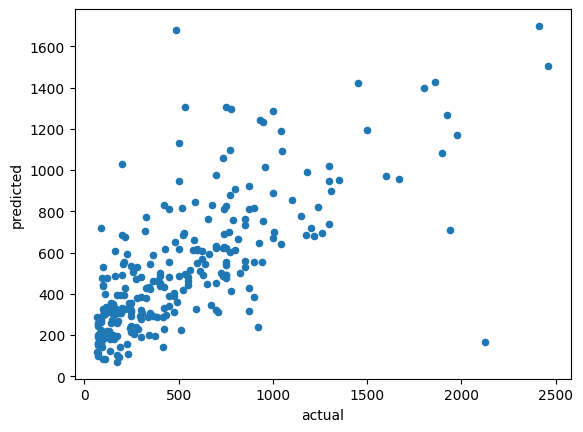

In [95]:
y_pred = best_fitted.predict(X)
target = pd.DataFrame()
target["actual"] = y
target["predicted"] = y_pred
target.plot.scatter(x = "actual", y = "predicted")